In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in the words
words = open('/Users/rajesh/Documents/Datasets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# Build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtrg, Ytrg = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# Set up the MLP (multi-layer perceptron)
n_embd = 10     # Dimensionality of the character embedding vectors
n_hidden = 200  # Number of neurons in the hidden layer of the MLP

# Set up the network parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [8]:
for p in parameters:
    p.requires_grad = True

In [9]:
sum(p.nelement() for p in parameters) # Number of parameters

11897

In [10]:
# Set up training of the neural network
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Construct minibatch
    idx = torch.randint(0, Xtrg.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrg[idx], Ytrg[idx]     # batch X, Y

    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Parameter update
    eta = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data += -eta * p.grad
        
    # Track progress statistics
    if i % 10000 == 0:
            print(f'{i:7d} / {max_steps:7d} : {loss.item():.4f}')
        
    lossi.append(loss.log10().item())

# print(loss.item())

      0 /  200000 : 27.8817
  10000 /  200000 : 2.9550
  20000 /  200000 : 2.5960
  30000 /  200000 : 2.8739
  40000 /  200000 : 2.0954
  50000 /  200000 : 2.4711
  60000 /  200000 : 2.4224
  70000 /  200000 : 2.1450
  80000 /  200000 : 2.3150
  90000 /  200000 : 2.3512
 100000 /  200000 : 2.0754
 110000 /  200000 : 2.4186
 120000 /  200000 : 1.9340
 130000 /  200000 : 2.4763
 140000 /  200000 : 2.2390
 150000 /  200000 : 2.1413
 160000 /  200000 : 2.1554
 170000 /  200000 : 1.8018
 180000 /  200000 : 2.0026
 190000 /  200000 : 1.8852


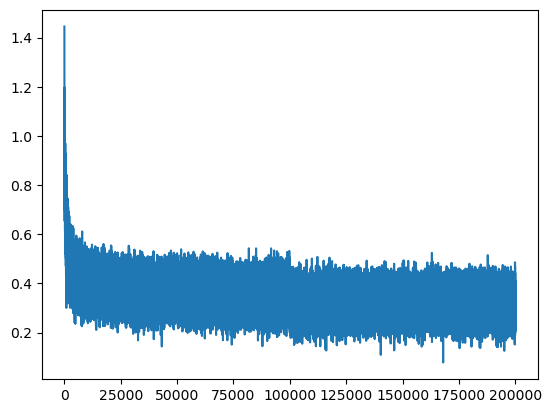

In [11]:
# Plot Steps against the Loss
plt.plot(lossi)

In [12]:
# Calculate the training and validation set loss

@torch.no_grad()     # Decorator to tell PyTorch that the code below does not require bookkeeping for gradients
                     # This improves execution efficiency
    
def calculate_split_loss(split):
    x,y = {
        'train': (Xtrg, Ytrg),
        'val': (Xval, Yval),
        'test': (Xtst, Ytst)
    }[split]
    
    emb = C[x]     # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)        # hidden layer activation (N, n_hidden)
    logits = h @ W2 + b2                    # output layer activation (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
calculate_split_loss('train')
calculate_split_loss('val')

    
    

train 2.1276285648345947
val 2.172778606414795


In [14]:
# Sample from the model
g= torch.Generator().manual_seed(2147473647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size     # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])]        # (1, block_size, n_embd)
        embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)
        h = torch.tanh(embcat @ W1 + b1)        # hidden layer activation (N, n_hidden)
        logits = h @ W2 + b2                    # output layer activation (N, vocab_size)
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(idx)
        # Shift the context window
        context = context[1:] + [idx]
        # Break if we sample the special token '.'
        if (idx == 0):
            break
            
    # Decode and print the generated names
    print(''.join(itos[i] for i in out))

mazili.
nestoruetton.
xadal.
meran.
semy.
keana.
xis.
wan.
jayley.
nouk.
afaixty.
hazmet.
zerrinn.
ariak.
kaylyn.
josandristoryel.
colie.
arna.
nah.
araley.


In [ ]:
# Issues with the neural network
# Intial loss is very high ~28.887
# This is because the weights and biases when initialized to random numbers take on very large values.
# The first few epochs are spent squashing down these randomly initialized high weights.

# Trick: Multiply the weights by 0.1 or 0.01

In [20]:
# Set up the MLP (multi-layer perceptron)
n_embd = 10     # Dimensionality of the character embedding vectors
n_hidden = 200  # Number of neurons in the hidden layer of the MLP

# Set up the network parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.3
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]

In [21]:
for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # Number of parameters

11897

In [22]:
# Train the neural network

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Construct minibatch
    idx = torch.randint(0, Xtrg.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrg[idx], Ytrg[idx]     # batch X, Y

    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Parameter update
    eta = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data += -eta * p.grad
        
    # Track progress statistics
    if i % 10000 == 0:
            print(f'{i:7d} / {max_steps:7d} : {loss.item():.4f}')
        
    lossi.append(loss.log10().item())

# print(loss.item())

      0 /  200000 : 7.2157
  10000 /  200000 : 2.0785
  20000 /  200000 : 2.3764
  30000 /  200000 : 2.4629
  40000 /  200000 : 1.9597
  50000 /  200000 : 2.4472
  60000 /  200000 : 2.3848
  70000 /  200000 : 2.1217
  80000 /  200000 : 2.1824
  90000 /  200000 : 2.1229
 100000 /  200000 : 1.8579
 110000 /  200000 : 2.1681
 120000 /  200000 : 1.8689
 130000 /  200000 : 2.4107
 140000 /  200000 : 2.2492
 150000 /  200000 : 2.1073
 160000 /  200000 : 1.7896
 170000 /  200000 : 1.7932
 180000 /  200000 : 1.9447
 190000 /  200000 : 1.7898


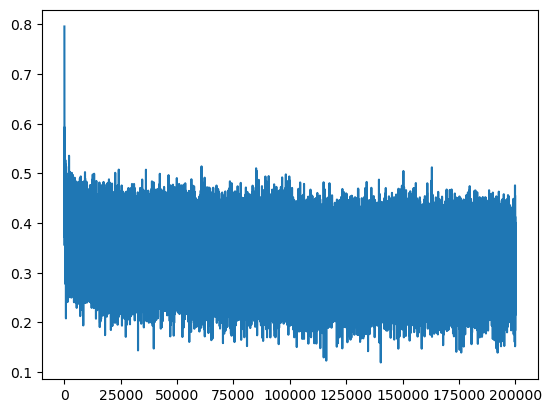

In [43]:
# Plot the loss
plt.plot(lossi)

In [44]:
# Calculate training and validation loss

calculate_split_loss('train')
calculate_split_loss('val')

train 2.0870563983917236
val 2.11906099319458


In [ ]:
# Notes:
# The loss for the first epoch is 7.21
# The training and validation losses are better than what we got previously with randomly initialized weights

# The issue with the tanh activation function is that large values of pre-activation will result in tanh giving -1 or +1
# Neurons where the activation is either -1 or +1 for all inputs are effectively deade neurons (with 0 gradient). These will not learn.
# This is another reason to make sure that weight initialization is done carefully (like we did above)
# There is a very principled way of weight initialization depending on the loss function that uses gain / sqrt(fan_in) as the multiplicative factor.

# More recent innovations that we will discuss next make it less important to so carefully initialize the weights.

# Video: 40:47


In [26]:
# Let's examine the hpreact
# hpreact takes the size of the batch (32 examples) X the number of hidden layer neurons (200)
hpreact.shape

torch.Size([32, 200])

In [27]:
# Mean and std of the hpreact
# Calculate over the 0th dimension; keepdim=True for broadcasting
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [28]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [55]:
# Set up the MLP (multi-layer perceptron)
n_embd = 10     # Dimensionality of the character embedding vectors
n_hidden = 200  # Number of neurons in the hidden layer of the MLP

# Set up the network parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.3
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.01
# Batch Normalization hyperparameters
bngain = torch.ones(1,n_hidden)
bnbias = torch.zeros(1,n_hidden)

# Running mean and std of the batch normalization; 0 mean and 1 std
bnmean_running = torch.zeros(1,n_hidden)
bnstd_running = torch.ones(1,n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]


In [56]:
for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # Number of parameters

12297

In [57]:
# Batch Normalization Reference: 
# Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariance Shift by Ioffe S. and Szegedy, C. Google 2015
# Makes it possible to train deep neural networks very reliably
# Main idea: Normalize the hidden layer pre-activations to a Gaussian distribution (i.e., zero mean and 1 STD).
# Batch normalization has a hidden (or serendipitous) regularizing effect due to which we haven't been able to remove it.
# Batch normalization layers are sprinkled through the deep neural network typically following linear layers or convolutional layers.

# Train the neural network with Batch Normalization

max_steps = 200000
batch_size = 32
epsilon = 0.001
lossi = []

for i in range(max_steps):
    
    # Construct minibatch
    idx = torch.randint(0, Xtrg.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrg[idx], Ytrg[idx]     # batch X, Y

    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    
    # Note: In practice when we use the batch normalization layer, the bias b1 is actually being subtracted out
    # when we do hpreact - bmeani
    # Technically, linear or convolution layers that are followed by batch normalization don't need a bias term.
    # The bnbias (batch normalization bias will take care of biasing the output as necessary.
    
    # Deep neural networks typically have stacked blocks of the following 3 layers:
        # A linear or convolutional layer
        # A batch normalization layer
        # A non-linear layer e.g., tanh or relu
        
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    # Normalize the hpreact
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    # Note: the +epsilon is a trick to prevent division by 0 in the event that the batch has a 0 std
    hpreact = (hpreact - bnmeani)/(bnstdi+epsilon)
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # Scale and shift the hpreact
    hpreact = bngain * hpreact + bnbias
    
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Parameter update
    eta = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data += -eta * p.grad
        
    # Track progress statistics
    if i % 10000 == 0:
            print(f'{i:7d} / {max_steps:7d} : {loss.item():.4f}')
        
    lossi.append(loss.log10().item())

# print(loss.item())

      0 /  200000 : 3.7606
  10000 /  200000 : 2.1743
  20000 /  200000 : 2.4096
  30000 /  200000 : 2.4453
  40000 /  200000 : 1.9734
  50000 /  200000 : 2.3715
  60000 /  200000 : 2.4189
  70000 /  200000 : 2.0394
  80000 /  200000 : 2.3972
  90000 /  200000 : 2.1468
 100000 /  200000 : 1.9343
 110000 /  200000 : 2.3680
 120000 /  200000 : 2.0137
 130000 /  200000 : 2.4634
 140000 /  200000 : 2.3123
 150000 /  200000 : 2.1483
 160000 /  200000 : 1.9656
 170000 /  200000 : 1.7987
 180000 /  200000 : 2.0165
 190000 /  200000 : 1.9374


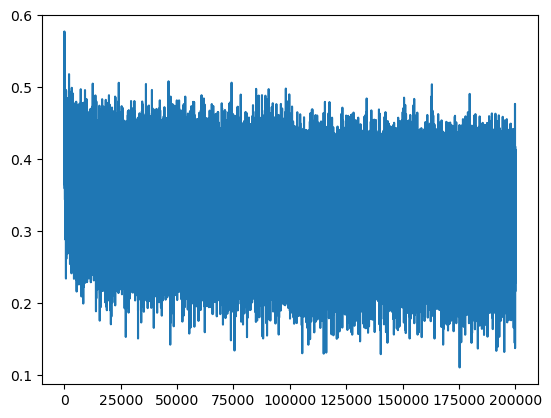

In [58]:
# Plot the loss
plt.plot(lossi)

In [60]:
# Calibrate the batch normalization statistics

# In practice we will calculate bnmean and bnstd as part of the training process itself as opposed to a post processing step
# See the computation of bnmean_running and bnmean_std
# Given those two we don't need this post processing step any longer.

with torch.no_grad():
    # Do a forward pass through the training set
    emb = C[Xtrg]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # Measure the mean and standard deviation over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [61]:
print('Running bn mean = ', bnmean_running)
print('bnmean post process = ', bnmean)
print('Running bn std = ', bnstd_running)
print('bnstd post process = ', bnstd)

Running bn mean =  tensor([[-2.6382,  0.4997, -1.1216,  1.7707,  1.4710,  1.0265,  3.1930, -2.2119,
          0.2754,  2.2594, -1.7007, -2.4569, -0.3057, -0.4924, -1.1915, -0.0725,
          1.2977, -3.1257, -0.2751,  1.6390, -0.5537, -0.2362,  0.6417,  0.8748,
          1.6148,  0.6528,  2.2342,  0.4815, -0.6995,  2.5032,  1.0200, -0.9064,
         -0.3400,  0.4844, -0.3099, -0.3734, -1.2450, -0.0759, -0.7493,  1.1143,
         -0.7477, -1.2539, -0.8855, -0.5794,  1.2648,  1.2919,  1.2440, -0.9035,
          2.4199,  0.9934, -0.2171,  0.0810,  2.2255,  1.4425,  0.6078, -2.3665,
         -0.2632, -0.0120,  0.7370, -1.2966, -0.4456,  1.1140,  1.9546,  0.2783,
          1.9021,  1.4024, -0.7127,  1.4324, -0.7439, -0.1224, -0.2504, -0.5484,
          1.3495, -1.9634, -2.2044, -0.1225,  0.7970,  0.3531,  1.5397,  1.1394,
          0.2771,  1.2460,  2.3193,  0.8328,  0.6375, -0.3931, -1.3978,  0.5449,
          2.3116,  0.4911, -0.6135, -0.1172, -0.6234, -0.1772, -1.0089,  0.2616,
         

In [62]:
# Calculate the training and validation set loss

@torch.no_grad()     # Decorator to tell PyTorch that the code below does not require bookkeeping for gradients
                     # This improves execution efficiency
    
def calculate_split_loss(split):
    x,y = {
        'train': (Xtrg, Ytrg),
        'val': (Xval, Yval),
        'test': (Xtst, Ytst)
    }[split]
    
    emb = C[x]     # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    # Normalize the hpreact
    # hpreact = (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True)
    
    # Use the bnmean and bnstd estimated over the training set
    # hpreact = (hpreact - bnmean)/bnstd
    
    # Use the running mean and stdy instead
    hpreact = (hpreact - bnmean_running)/bnstd_running
    
    # Scale and shift the hpreact
    hpreact = bngain * hpreact + bnbias
    
    h = torch.tanh(hpreact) # hidden layer activation

    logits = h @ W2 + b2                    # output layer activation (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
calculate_split_loss('train')
calculate_split_loss('val')


train 2.0708489418029785
val 2.109968662261963


In [ ]:
# Summary + Translate NN to more PyTorch like code

In [74]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)     # Gain of the Batch Norm
        self.beta = torch.zeros(dim)     # Bias of the Batch Norm
        # buffers (trained with a running 'momentum update')
        # Running mean and variance
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [75]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []     # update to data ratio shows how much / how fast the neuron is learning

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtrg.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrg[ix], Ytrg[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    #for layer in layers:
    #    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    #if i >= 1000:
    #    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1508
 120000/ 200000: 2.1813
 130000/ 200000: 2.0889
 140000/ 200000: 1.8096
 150000/ 200000: 1.9132
 160000/ 200000: 1.9793
 170000/ 200000: 1.9654
 180000/ 200000: 2.2462
 190000/ 200000: 1.9601


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

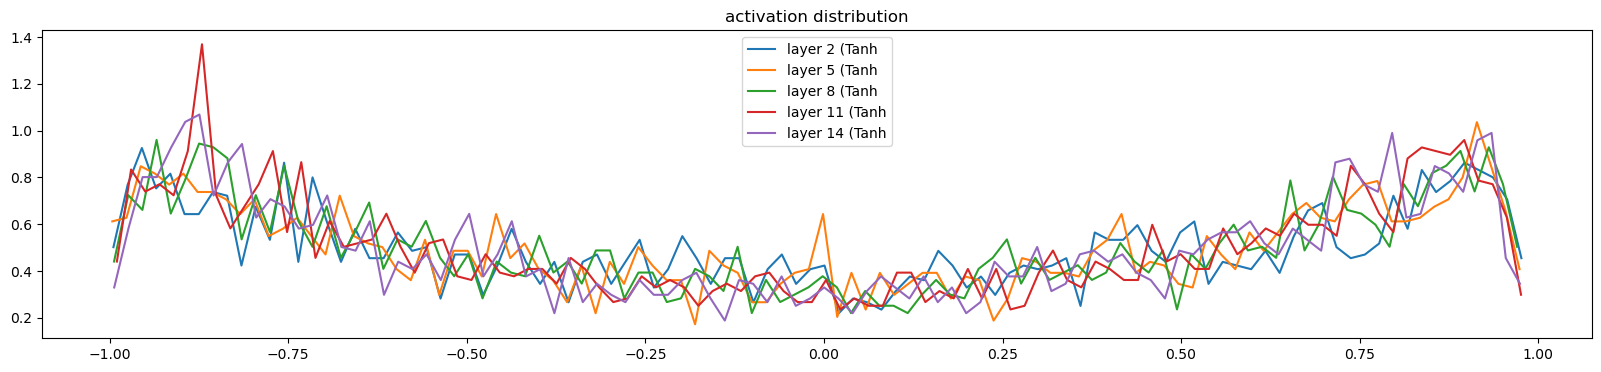

In [69]:
# Debugging Tool
# Visualize the histogram of the outputs of the tanh layers
# If the frequencies at -1 or +1 are very high then several neurons are operating in the saturated regions and hence not learning (much).
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.640702e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

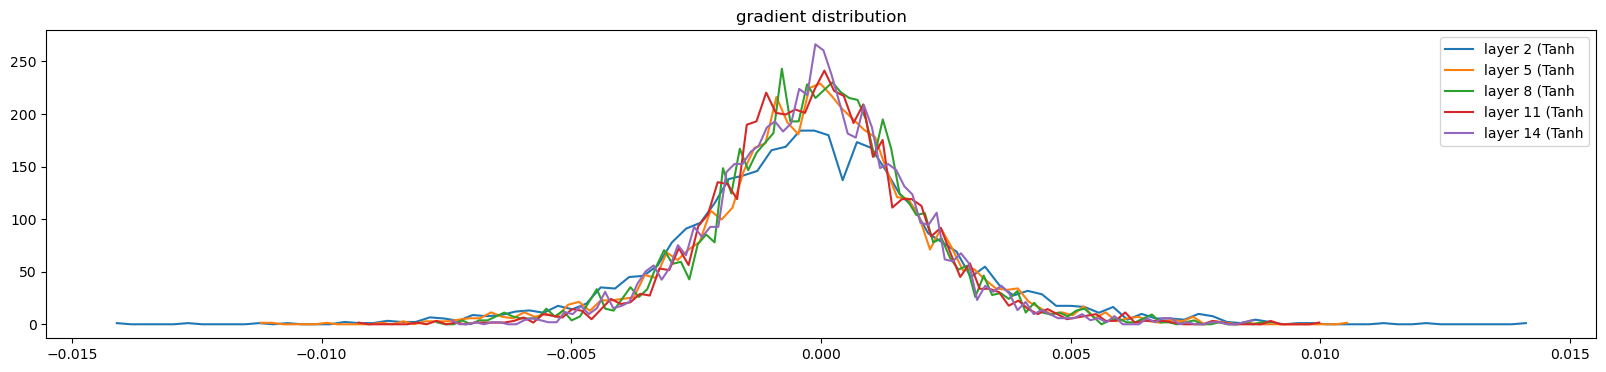

In [70]:
# Visualize the histogram of the gradients of the tanh layer
# The gradients should be pretty much normally distributed.

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.020534e-03 | grad:data ratio 8.012630e-03
weight  (30, 100) | mean +0.000246 | std 9.241073e-03 | grad:data ratio 4.881089e-02
weight (100, 100) | mean +0.000113 | std 7.132877e-03 | grad:data ratio 6.964617e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742182e-03 | grad:data ratio 5.631478e-02
weight (100, 100) | mean +0.000032 | std 5.672207e-03 | grad:data ratio 5.570127e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


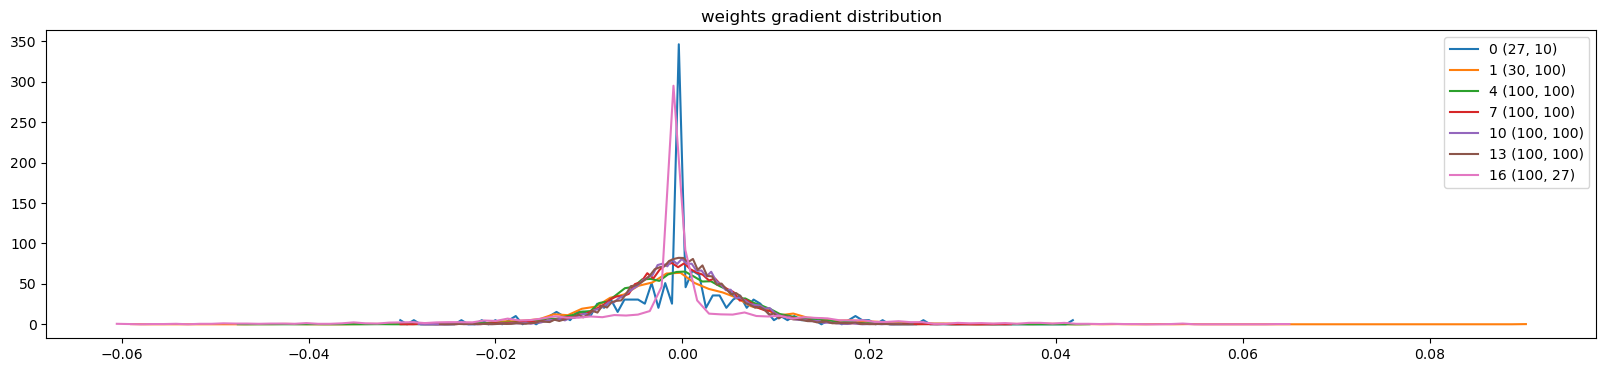

In [71]:
# Visualize histograms of the weights

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

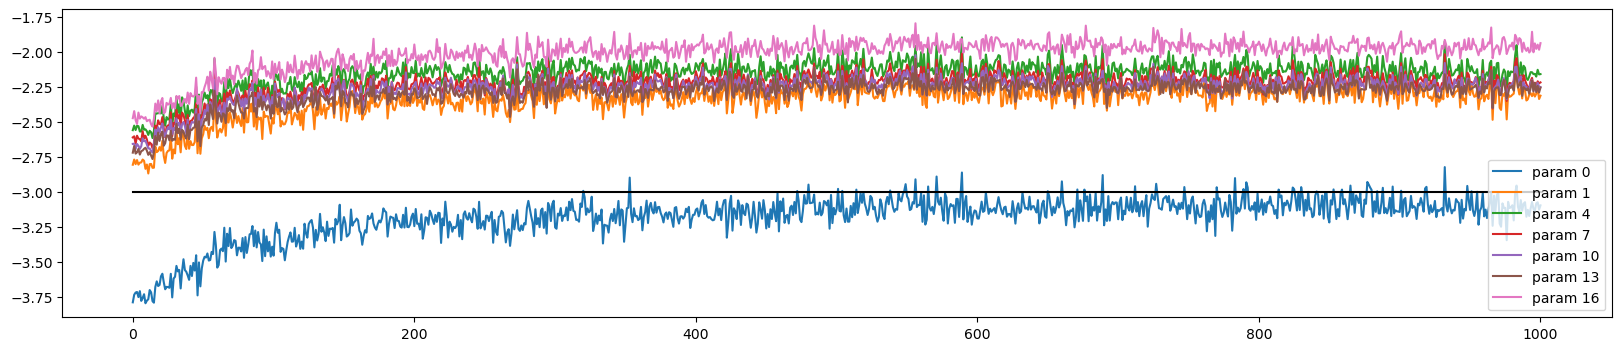

In [72]:
# Plot update to data ratio
# If the ratio hovers around -3 (i.e., 1e-3) then the learning is happening at the right pace.
# Much higher ratios indicate very fast learning which may cause oscillation around the optimum
# Much lower ratios indicate very slow learning

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [76]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtrg, Ytrg),
        'val': (Xval, Yval),
        'test': (Xtst, Ytst),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 1.999863624572754
val 2.0770881175994873
